In [10]:
import os
import cv2
from time import time
import numpy as np
import habitat
from env import Env
import quaternion
from IPython.display import clear_output
import matplotlib.pyplot as plt
from arguments import init_config
from tqdm import tqdm
%matplotlib inline

In [3]:
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from vo_modules import VisualOdometry as VO
from libs.general.utils import *
from libs.utils import *

In [4]:
config = init_config()
config.defrost()
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.  # 0.1
config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.  # 0.5
config.SIMULATOR.TURN_ANGLE = 5  # 10
config.SIMULATOR.TILT_ANGLE = 5  # 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.125  # 0.25
config.freeze()
config['DATASET']['SPLIT'] = 'train'
env = Env(config=config)

2020-06-11 15:29:51,166 Initializing dataset PointNav-v1
Initializing dataset PointNav-v1
2020-06-11 15:31:17,396 initializing sim Sim-v0
initializing sim Sim-v0
2020-06-11 15:31:22,334 Initializing task Nav-v0
Initializing task Nav-v0


In [5]:
default_config_file = "options/kitti/kitti_default_configuration.yml"
config_files = [default_config_file, './options/custom_configuration.yml']
cfg = merge_cfg(config_files)
cfg.seq = str(cfg.seq)

In [36]:
# Random seed
SEED = cfg.seed
np.random.seed(SEED)

vo = VO(cfg)
vo.setup()

==> initialize LiteFlowNet with [model/network-default.pytorch]: 


In [37]:
done = False
img_id = 0
res = env.reset(0)[0]

start_time = time()
pos_start = env.sim.get_agent_state().position
observations = env.sim.get_observations_at()
pos = env.sim.get_agent_state().position - pos_start
q = env.sim.get_agent_state().rotation

In [38]:
vo.rgb_d_pose_pair = vo.synchronize_rgbd_pose_pairs()
len_seq = len(vo.rgb_d_pose_pair)
main_start_time = time()
start_frame = 0

In [39]:
for img_id in tqdm(range(start_frame, len_seq)):
    vo.tracking_mode = "Ess. Mat."

    """ Data reading """
    start_time = time()

    # Initialize ids and timestamps
    vo.cur_data['id'] = img_id

    if vo.cfg.dataset == "kitti":
        vo.cur_data['timestamp'] = img_id
    elif "tum" in vo.cfg.dataset:
        vo.cur_data['timestamp'] = sorted(list(vo.rgb_d_pose_pair.keys()))[img_id]

    # Reading image
    if vo.cfg.dataset == "kitti":
        img = read_image(vo.img_path_dir+"/{:06d}.{}".format(img_id, vo.cfg.image.ext), 
                            vo.cfg.image.height, vo.cfg.image.width)
    elif "tum" in vo.cfg.dataset:
        img = read_image(vo.img_path_dir+"/{:.6f}.{}".format(vo.cur_data['timestamp'], vo.cfg.image.ext),
                            vo.cfg.image.height, vo.cfg.image.width)
    img_h, img_w, _ = image_shape(img)
    vo.cur_data['img'] = img
    vo.timers.timers["img_reading"].append(time()-start_time)

    # Reading/Predicting depth
    if vo.depth_src is not None:
        vo.cur_data['raw_depth'] = vo.load_depth(
                        vo.depth_seq_dir, 
                        vo.rgb_d_pose_pair[vo.cur_data['timestamp']]['depth'], 
                        vo.depth_src, 
                        [img_h, img_w], 
                        dataset=vo.cfg.dataset,
                        )
    else:
        start_time = time()
        vo.cur_data['raw_depth'] = \
                vo.deep_models['depth'].inference(img=vo.cur_data['img'])
        vo.cur_data['raw_depth'] = cv2.resize(vo.cur_data['raw_depth'],
                                            (img_w, img_h),
                                            interpolation=cv2.INTER_NEAREST
                                            )
        vo.timers.timers['Depth-CNN'].append(time()-start_time)
    vo.cur_data['depth'] = preprocess_depth(vo.cur_data['raw_depth'], vo.cfg.crop.depth_crop, [vo.cfg.depth.min_depth, vo.cfg.depth.max_depth])

    """ Visual odometry """
    start_time = time()
    if vo.tracking_method == "hybrid":
        vo.tracking_hybrid()
    else:
        raise NotImplementedError
    vo.timers.timers["tracking"].append(time()-start_time)

    """ Visualization """
    start_time = time()

    vo.timers.timers["visualization"].append(time()-start_time)

    """ Update reference and current data """
    vo.ref_data, vo.cur_data = vo.update_ref_data(
                            vo.ref_data,
                            vo.cur_data,
                            vo.window_size,
                            vo.keyframe_step
    )


  2%|▏         | 2/120 [00:00<00:33,  3.52it/s]/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
  2%|▎         | 3/120 [00:01<00:41,  2.83it/s]/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
  3%|▎         | 4/120 [00:01<00:45,  2.56it/s]/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default

In [31]:
vo.tracking_mode = "Ess. Mat."
start_time = time()
vo.cur_data['id'] = img_id
vo.cur_data['timestamp'] = sorted(list(vo.rgb_d_pose_pair.keys()))[img_id]
vo.cur_data['img'] = observations['rgb']
vo.timers.timers["img_reading"].append(time()-start_time)
vo.cur_data['raw_depth'] = observations['depth'][:,:,0]
vo.cur_data['depth'] = preprocess_depth(vo.cur_data['raw_depth'], vo.cfg.crop.depth_crop, [vo.cfg.depth.min_depth, vo.cfg.depth.max_depth])
start_time = time()
vo.tracking_hybrid()
vo.timers.timers["tracking"].append(time()-start_time)
start_time = time()
vo.timers.timers["visualization"].append(time()-start_time)

vo.ref_data, vo.cur_data = vo.update_ref_data(
                                    vo.ref_data,
                                    vo.cur_data,
                                    vo.window_size,
                                    vo.keyframe_step)

In [32]:
while not done:
    img_id+=1
    observations, info, done = env.step(0, ideal_action=True)
    pos_start = env.sim.get_agent_state().position
    observations = env.sim.get_observations_at()
    pos = env.sim.get_agent_state().position - pos_start
    q = env.sim.get_agent_state().rotation
    
    vo.tracking_mode = "Ess. Mat."
    start_time = time()
    vo.cur_data['id'] = img_id
    vo.cur_data['timestamp'] = sorted(list(vo.rgb_d_pose_pair.keys()))[img_id]
    vo.cur_data['img'] = observations['rgb']
    vo.timers.timers["img_reading"].append(time()-start_time)
    vo.cur_data['raw_depth'] = observations['depth'][:,:,0]
    vo.cur_data['depth'] = preprocess_depth(vo.cur_data['raw_depth'], vo.cfg.crop.depth_crop, [vo.cfg.depth.min_depth, vo.cfg.depth.max_depth])
    start_time = time()
    vo.tracking_hybrid()
    vo.timers.timers["tracking"].append(time()-start_time)
    start_time = time()
    vo.timers.timers["visualization"].append(time()-start_time)

    vo.ref_data, vo.cur_data = vo.update_ref_data(
                                        vo.ref_data,
                                        vo.cur_data,
                                        vo.window_size,
                                        vo.keyframe_step)

   # break

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior i

IndexError: list index out of range

In [40]:
timestamps = sorted(list(vo.rgb_d_pose_pair.keys()))
global_poses_arr = convert_SE3_to_arr(vo.global_poses, timestamps)

In [41]:
xs = []
ys = []
zs = []
xsa = []
ysa = []
zsa = []
for i in global_poses_arr:
    pose = global_poses_arr[i]
    z, y, x = mat2euler(pose[:3, :3])
    xsa.append(x)
    ysa.append(y)
    zsa.append(z)
    tx, ty, tz = pose[:3, 3]
    xs.append(tx)
    ys.append(ty)
    zs.append(tz)

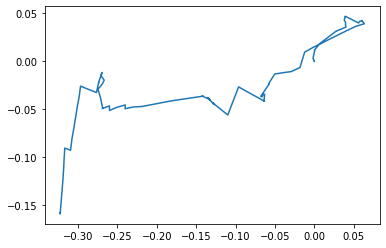

In [42]:
plt.plot(xs,zs)

In [41]:
a = preprocess_depth(vo.cur_data['raw_depth'], vo.cfg.crop.depth_crop, [vo.cfg.depth.min_depth, vo.cfg.depth.max_depth])

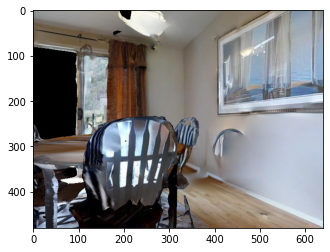

In [43]:
plt.imshow(vo.cur_data['img'])

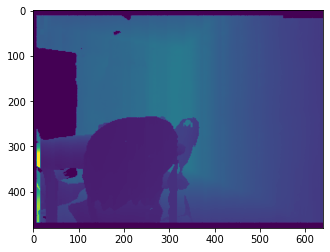

In [44]:
plt.imshow(observations['depth'][:,:,0])

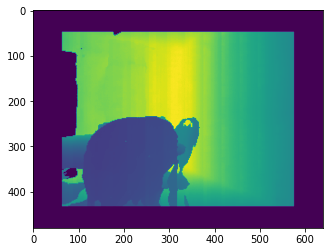

In [42]:
plt.imshow(a)